In [ ]:
# Core Imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from tensorflow.keras import layers, models, callbacks, losses, mixed_precision

# Scikit-learn helpers
from sklearn.compose        import ColumnTransformer
from sklearn.preprocessing   import OneHotEncoder, StandardScaler
from sklearn.decomposition   import TruncatedSVD
from sklearn.ensemble        import IsolationForest
from sklearn.metrics         import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split

# Seeding and Constants
RANDOM_STATE = 42
tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

mixed_precision.set_global_policy("mixed_float16") # faster training

BATCH      = 1024
CACHE_TRAIN = "./ae_train.cache" # cache for training data - saves memory
CACHE_VAL   = "./ae_val.cache"   # cache for validation data - saves memory


In [ ]:
# Preprocess helper
def load_and_prepare(path_csv, path_labels=None):
    """
    Load a transactions CSV and optional labels JSON.
    Adds hour_of_day & day_of_week. Supports either
    string or numeric amount.
    """
    df = pd.read_csv(
        path_csv,
        usecols=["id", "date", "amount", "merchant_city", "mcc"]
    )
    df["date"] = pd.to_datetime(df["date"])

    if pd.api.types.is_numeric_dtype(df["amount"]):
        df["amount"] = df["amount"].astype(float)
    else:
        df["amount"] = (
            df["amount"]
              .astype(str)
              .str.replace(r"[$,]", "", regex=True)
              .astype(float)
        )

    df = df.rename(columns={"id": "transaction_id",
                            "merchant_city": "location"})
    df["hour_of_day"] = df["date"].dt.hour
    df["day_of_week"] = df["date"].dt.weekday

    if path_labels is not None:
        lbl = (
            pd.read_json(path_labels)
              .reset_index()
              .rename(columns={"index": "transaction_id"})
              .replace({"target": {"Yes": 1, "No": 0}})
        )
        df = df.merge(lbl, on="transaction_id")

    # inject target column if it exists
    df_target = pd.read_csv(path_csv)
    if "target" in df_target.columns:
        df["target"] = df_target["target"].astype(int)

    return df

In [3]:
# ColumnTransformer + SVD reducer
cat_cols = ["location", "mcc"]
num_cols = ["amount", "hour_of_day", "day_of_week"]

base_pre = ColumnTransformer(
    transformers=[
        ("cat",
         OneHotEncoder(handle_unknown="ignore",
                       sparse_output=True,
                       dtype=np.int8),
         cat_cols),
        ("num", StandardScaler(), num_cols)
    ],
    sparse_threshold=0.3
)

# Reduce high-dim sparse matrix to 200 dense features
svd = TruncatedSVD(
        n_components=200,
        algorithm="randomized",
        n_iter=5,
        random_state=RANDOM_STATE
)


In [ ]:
# Train Isolation Forest on Kaggle
kag_csv   = "../assets/kaggle_data/transactions_data.csv"
kag_lbl   = "../assets/kaggle_data/train_fraud_labels.json"

train_df  = load_and_prepare(kag_csv, kag_lbl)
y_train   = train_df["target"]
X_train   = train_df.drop(columns=["transaction_id", "date", "target"])

X_train_sparse   = base_pre.fit_transform(X_train)
scaler = StandardScaler()
X_train_reduced  = svd.fit_transform(X_train_sparse)
X_train_scaled   = scaler.fit_transform(X_train_reduced)


iso = IsolationForest(
        n_estimators=300,
        contamination=0.0001,
        max_samples="auto",
        n_jobs=-1,
        random_state=RANDOM_STATE
)
iso.fit(X_train_scaled)

# Keep only normal points for AE training
mask_keep   = iso.predict(X_train_scaled) == 1
X_ae_dense  = scaler.transform(X_train_reduced[mask_keep]).astype("float32")
print("AE training set shape:", X_ae_dense.shape)


/var/folders/gd/d2vxxv2x60j28jw85n3wg5dw0000gn/T/ipykernel_18082/3860006748.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"target": {"Yes": 1, "No": 0}})


AE training set shape: (8914071, 200)


In [ ]:
# Train / validation datasets
X_train, X_val = train_test_split(
    X_ae_dense, test_size=0.20, random_state=RANDOM_STATE)

AUTOTUNE = tf.data.AUTOTUNE

def make_ds(X, cache_path):
    X = X.astype("float16")                      
    ds = tf.data.Dataset.from_tensor_slices((X, X))
    ds = ds.cache(cache_path)                     
    ds = ds.shuffle(buffer_size=min(20_000, len(X)),
                    seed=RANDOM_STATE)
    ds = ds.batch(BATCH)                         
    return ds.prefetch(AUTOTUNE)

ds_train = make_ds(X_train, CACHE_TRAIN)
ds_val   = make_ds(X_val,   CACHE_VAL)

# autoencoder
n_in = X_ae_dense.shape[1]
enc_units      = [128]
bottleneck_dim = 32
dec_units      = [128]

inp = layers.Input(shape=(n_in,))
x   = layers.GaussianNoise(0.02)(inp)

for u in enc_units:
    x = layers.Dense(u, kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(0.2)(x)

x = layers.Dense(bottleneck_dim,
                 kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.1)(x)

for u in dec_units:
    x = layers.Dense(u, kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)

out = layers.Dense(n_in, activation="linear", dtype="float32")(x)

ae = models.Model(inp, out)

lr_sched = tf.keras.optimizers.schedules.ExponentialDecay(
    1e-3, decay_steps=2_000, decay_rate=0.90)
opt = tf.keras.optimizers.AdamW(learning_rate=lr_sched, weight_decay=1e-5)

ae.compile(optimizer=opt,
           loss=losses.Huber(delta=1.0),
           run_eagerly=False)

early_stop = callbacks.EarlyStopping(
    patience=12, restore_best_weights=True, verbose=1)

history = ae.fit(
    ds_train,
    epochs=10,
    validation_data=ds_val,
    callbacks=[early_stop],
    verbose=2
)


2025-05-22 16:15:07.233404: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-05-22 16:15:07.233564: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2025-05-22 16:15:07.233741: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
2025-05-22 16:15:07.233892: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-22 16:15:07.233905: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


/opt/miniconda3/envs/pwc-autoencoder/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
2025-05-22 16:15:14.193058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


6965/6965 - 147s - 21ms/step - loss: 0.0767 - val_loss: 0.0598
Epoch 2/10
Epoch 2/10
6965/6965 - 146s - 21ms/step - loss: 0.0649 - val_loss: 0.0570
Epoch 3/10
6965/6965 - 146s - 21ms/step - loss: 0.0632 - val_loss: 0.0557
Epoch 4/10
6965/6965 - 146s - 21ms/step - loss: 0.0623 - val_loss: 0.0550
Epoch 5/10
6965/6965 - 146s - 21ms/step - loss: 0.0617 - val_loss: 0.0545
Epoch 6/10
6965/6965 - 148s - 21ms/step - loss: 0.0613 - val_loss: 0.0540
Epoch 7/10
6965/6965 - 148s - 21ms/step - loss: 0.0609 - val_loss: 0.0537
Epoch 8/10
6965/6965 - 148s - 21ms/step - loss: 0.0607 - val_loss: 0.0534
Epoch 9/10
6965/6965 - 149s - 21ms/step - loss: 0.0605 - val_loss: 0.0532
Epoch 10/10
6965/6965 - 151s - 22ms/step - loss: 0.0604 - val_loss: 0.0530
Restoring model weights from the end of the best epoch: 10.


In [6]:
# Compute AE threshold (99.99 percentile)
val_size  = int(0.1 * len(X_ae_dense))
recon_val = ae.predict(X_ae_dense[:val_size], batch_size=512, verbose=0)
err_val   = np.mean(np.square(recon_val - X_ae_dense[:val_size]), axis=1)

THRESH = np.percentile(err_val, 99.99)
print(f"Reconstruction-error threshold = {THRESH:.6f}")


Reconstruction-error threshold = 5.470049


In [ ]:
# Predict on chatgpt_data set
test_csv = "../assets/chatgpt_data/transactions_o3_5.csv"
test_lbl = None   # set path if you have labels

test_df   = load_and_prepare(test_csv, test_lbl)
has_label = "target" in test_df.columns
if has_label:
    y_test = test_df["target"]

X_test = test_df.drop(columns=["transaction_id", "date"] +
                                (["target"] if has_label else []))

# Isolation Forest Trimming
X_test_sparse   = base_pre.transform(X_test)
X_test_reduced  = svd.transform(X_test_sparse)
X_test_scaled   = scaler.transform(X_test_reduced)

if_flag = (iso.predict(X_test_scaled) == -1).astype(int)

# AE Prediction
recon_test = ae.predict(X_test_scaled.astype("float32"),
                        batch_size=1024, verbose=0)
err_test   = np.mean(np.square(recon_test - X_test_scaled), axis=1)
ae_flag    = (err_test > THRESH).astype(int)

y_pred = (if_flag | ae_flag)


Accuracy : 0.99774
Precision: 0.9989754098360656
Recall   : 0.8125
F1       : 0.8961397058823529


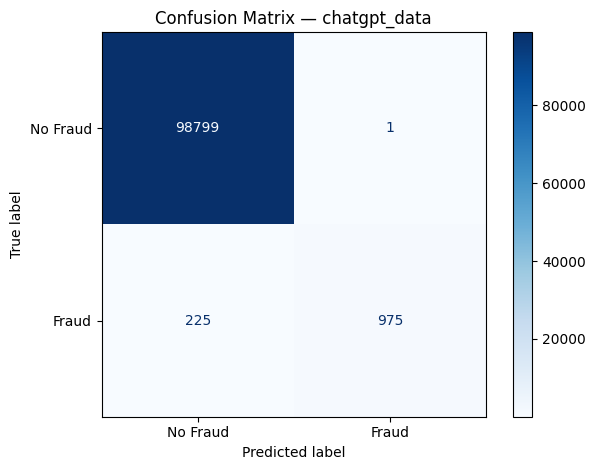

In [26]:
# Metrics
if has_label:
    print("Accuracy :",  accuracy_score(y_test, y_pred))
    print("Precision:",  precision_score(y_test, y_pred, zero_division=0))
    print("Recall   :",  recall_score(y_test, y_pred))
    print("F1       :",  f1_score(y_test, y_pred))

    cm   = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["No Fraud", "Fraud"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix — chatgpt_data")
    plt.tight_layout()
    plt.show()
else:
    print("Predictions generated (no ground-truth labels supplied).")